# KMNIST Model With Custom Neural Network Architecture (STEM, BACKBONE, CLASSIFIER)

### Description
The Stem takes as input an image I of size High x Width (28x28) and divides it into Np non-overlapping patches. Using Pytorch function nn.unfold(). Each patch has dimensions K x K (7x7). Each patch gets reshaped into a vector, then transformed to a feature vector of dimensions [32,16,49], Which will be input for backbone.
The backbone has collection of blocks, The MLP_BLOCK contains MLP1 and MLP2 with non-linear activation function and input of both MLP layer is transposed first. And another custom block is created with linear layers with nn.BatchNorm1d, nn.Dropout(0.25) and ReLU() – Activation Function. A series of Block B1,B2, …B5 is created. 
The classifier takes output of last Block B5, compute mean and then feed the mean features to SoftMax regression classifier to classify.
The model combines STEM, BACKBONE and CLASSIFIER into a network.

### Import All Libraries

In [1]:
#import 
import sys
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu

Using device: cuda
NVIDIA GeForce RTX 2080 Super with Max-Q Design


## Download and load Dataset : KMNIST

In [2]:
# datasets
train_data = datasets.KMNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
display(train_data)
test_data = datasets.KMNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)
display(test_data)

batch_size=32
#Data Loader
train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=1)
test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size,num_workers=1)

Dataset KMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Dataset KMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Data visualization

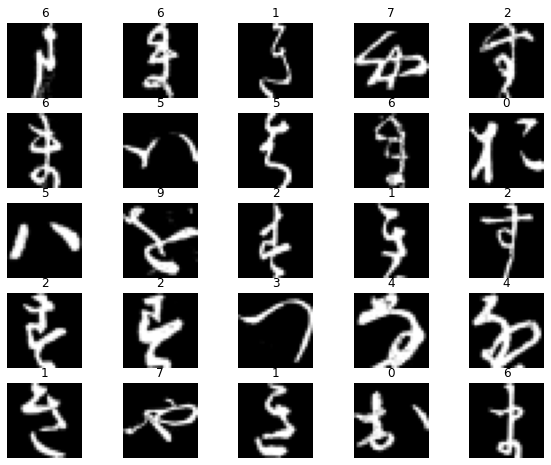

In [3]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### IMPLEMENTING STEM

INPUT IMAGE


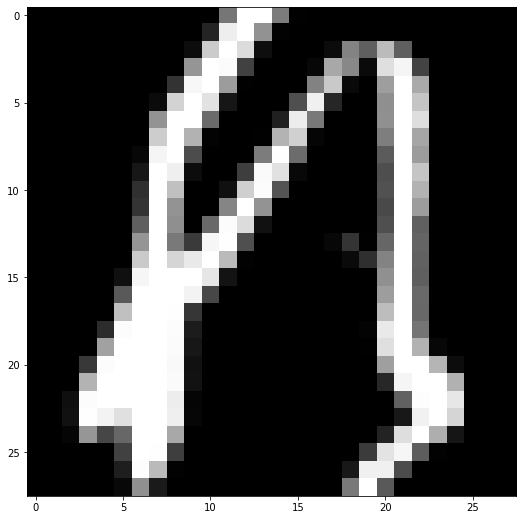

In [4]:
print("INPUT IMAGE")
img, label = train_data[0]
fig = plt.figure(figsize =(9,9))
plt.imshow(img.squeeze(), cmap="gray")

IMAGE PATCH OF INPUT IMAGE of 7 x 7


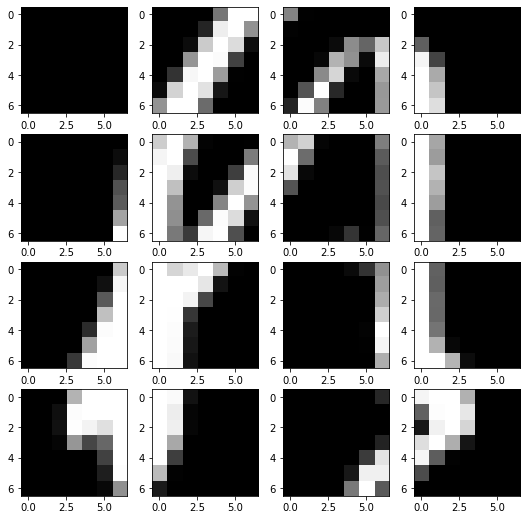

In [5]:
from torch import reshape
train_diter = iter(train_iter)
x = next(train_diter)

img_height = int(x[0].size(3))
img_width = int(x[0].size(2))
HnWToPatch = 7
patch_size = (img_height*img_width)//((img_height//HnWToPatch) * (img_width//HnWToPatch))

patch_image = x[0].unfold(2, HnWToPatch, HnWToPatch).unfold(3, HnWToPatch, HnWToPatch)
patched_image = patch_image[0].reshape([-1,HnWToPatch,HnWToPatch])
fig = plt.figure(figsize =(9,9))
rows = 28//HnWToPatch
columns = 28//HnWToPatch
print(f"IMAGE PATCH OF INPUT IMAGE of {HnWToPatch} x {HnWToPatch}")
for i in range(len(patched_image)):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(patched_image[i].numpy(), cmap='gray')
plt.show()

# DEFINE VARIABLES

In [6]:
train_diter = iter(train_iter)
x = next(train_diter)

img_height = int(x[0].size(3))
img_width = int(x[0].size(2))
H_W = img_height*img_width
HnWToPatch = 7 # CREATING 7 x 7 Patch
features = (img_height*img_width)//((img_height//HnWToPatch) * (img_width//HnWToPatch)) # 49
patch_size = int(H_W/features) # 16 patches
print("Expected output tensor from STEM : [{},{},{}]".format(batch_size,patch_size,features))

Expected output tensor from STEM : [32,16,49]


## THE STEM

In [7]:
class STEM(nn.Module):
    def __init__(self, HnWToPatch, img_height, img_width):
        super().__init__()
        self.HnWToPatch = HnWToPatch
        self.features = (img_height*img_width)//((img_height//HnWToPatch) * (img_width//HnWToPatch))
        self.singlehiddenMLP = torchvision.ops.MLP(in_channels=self.features,hidden_channels=(self.features,))

    def img_patch(self,in_img):
        L = []
        in_img = in_img.unfold(2, self.HnWToPatch, self.HnWToPatch).unfold(3, self.HnWToPatch, self.HnWToPatch)
        for img in in_img:
          patch = img.flatten()
          patch = torch.split(patch,self.features)
          patch = torch.stack(list(patch), dim=0)
          L.append(patch)
        non_overlaping_patch = torch.stack(L)
        return non_overlaping_patch # non-overlapping patches

    def forward(self,x):
        assert x.size()[2] * x.size()[3] // self.HnWToPatch != 0 # Reshape
        x = self.img_patch(x)
        x = self.singlehiddenMLP(x) #single hidden layer MLP
        return x     

In [8]:
print(STEM(HnWToPatch,img_height,img_width))

STEM(
  (singlehiddenMLP): MLP(
    (0): Linear(in_features=49, out_features=49, bias=True)
    (1): Dropout(p=0.0, inplace=True)
  )
)


## THE BACKBONE

In [9]:
# MLP BLOCKS
class MLP_Block(nn.Module):
    def __init__(self, features, patch_size):
        super().__init__()
        self.MLP1 = nn.Sequential(
            nn.Linear(in_features=features, out_features= features),
            nn.BatchNorm1d(num_features=patch_size),
            nn.Linear(in_features=features, out_features= features),
            nn.BatchNorm1d(num_features=patch_size),
        )
        
        self.MLP2 = nn.Sequential(
            nn.Linear(in_features=patch_size, out_features=patch_size),
            nn.BatchNorm1d(num_features=features),
            nn.Linear(in_features=patch_size, out_features=patch_size),
            nn.BatchNorm1d(num_features=features),
        )
        
    def forward(self, x):
        x = x.transpose( 1, 2) # input gets transposed
        x = self.MLP1(x) # First MLP
        x = x.transpose( 1, 2) # input gets transposed
        x = self.MLP2(x) # Second MLP    
        return x 

## Custom BLOCK

class Block(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.C_MLP = nn.Sequential(
            nn.Linear(in_features=input_channels, out_features= input_channels),
            nn.BatchNorm1d(num_features=input_channels),
            nn.Dropout(0.25),
            nn.ReLU(),
            nn.Linear(in_features=input_channels, out_features= output_channels),
            nn.BatchNorm1d(num_features=output_channels),
            nn.Dropout(0.25),
            nn.ReLU()            
        )
    def forward(self, x):
        x = self.C_MLP(x)
        return x 

In [10]:
print(MLP_Block(features, patch_size))
print(Block(784, 392))

MLP_Block(
  (MLP1): Sequential(
    (0): Linear(in_features=49, out_features=49, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=49, out_features=49, bias=True)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (MLP2): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Block(
  (C_MLP): Sequential(
    (0): Linear(in_features=784, out_features=784, bias=True)
    (1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.25, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=784, out_features=392, bias=True)
    (5): BatchNorm1d(392, eps=1e-05, mo

## THE CLASSIFIER

In [11]:
class CLASSIFIER(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.num_class = num_class
        self.last = nn.Linear(features,num_class)
    def forward(self, x):
        x = torch.mean(x,axis=1, keepdim=False) # mean feature
        x = self.last(x)
        x = torch.nn.functional.log_softmax(x,dim=1) # softmax regression classifier
        return x

In [12]:
print(CLASSIFIER(10))

CLASSIFIER(
  (last): Linear(in_features=49, out_features=10, bias=True)
)


## MODEL

In [13]:
class NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.Stem = STEM(HnWToPatch, img_height, img_width) # 4 28 28
        self.B1 = MLP_Block(patch_size, features)
        self.B2 = MLP_Block(patch_size, features)
        self.B3 = Block(784, 392)
        self.B4 = Block(392, 196)
        self.B5 = Block(196, 784)
        self.classifier = CLASSIFIER(10) # 10 = Number of class
    def forward(self, x):
        x = self.Stem(x)
        x = self.B1(x)
        x = self.B2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.B3(x)
        x = self.B4(x)
        x = self.B5(x)
        Un_flatten = nn.Unflatten(1, (patch_size, features ))
        x = Un_flatten(x)
        x = self.classifier(x)
        return x
net = NET().to(device)

In [14]:
print(net)

NET(
  (Stem): STEM(
    (singlehiddenMLP): MLP(
      (0): Linear(in_features=49, out_features=49, bias=True)
      (1): Dropout(p=0.0, inplace=True)
    )
  )
  (B1): MLP_Block(
    (MLP1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=16, out_features=16, bias=True)
      (3): BatchNorm1d(49, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (MLP2): Sequential(
      (0): Linear(in_features=49, out_features=49, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Linear(in_features=49, out_features=49, bias=True)
      (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (B2): MLP_Block(
    (MLP1): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): BatchNorm1d(49, eps=1e-05, m

### Summary of the Model

In [15]:
from torchsummary import summary
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 16, 49]           2,450
           Dropout-2               [-1, 16, 49]               0
              STEM-3               [-1, 16, 49]               0
            Linear-4               [-1, 49, 16]             272
       BatchNorm1d-5               [-1, 49, 16]              98
            Linear-6               [-1, 49, 16]             272
       BatchNorm1d-7               [-1, 49, 16]              98
            Linear-8               [-1, 16, 49]           2,450
       BatchNorm1d-9               [-1, 16, 49]              32
           Linear-10               [-1, 16, 49]           2,450
      BatchNorm1d-11               [-1, 16, 49]              32
        MLP_Block-12               [-1, 16, 49]               0
           Linear-13               [-1, 49, 16]             272
      BatchNorm1d-14               [-1,

## Create the loss and optimiser and Training Parameters

In [16]:
from tqdm import tqdm
lr = 0.001
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
n_epochs = 100

# TRAINING

In [17]:
import numpy as np

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

val_acc = []
train_loss = []
train_acc = []
total_step = len(train_iter)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    for batch_idx, (data, target) in enumerate(tqdm(train_iter, desc=(f"Epoch {epoch}"))):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()# zero the parameter gradients
        # forward + backward + optimize
        outputs = net(data)
        target =target.to(device)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target).item()
        total += target.size(0)
    train_acc.append(100 * correct / total)
    train_loss.append(100 * running_loss/total_step)
    print(f'Train Loss: {(100 * running_loss / total_step):.2f} %  | Train Accuracy: {(100 * correct / total):.2f} % |', end =" ")
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_iter):
            data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
            outputs_t = net(data_t)
            target_t =target_t.to(device)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        print(f'Validation Accuracy: {(100 * correct_t / total_t):.2f} % |')
    net.train()

Epoch 1: 100%|██████████| 1875/1875 [00:30<00:00, 60.94it/s]


Train Loss: 75.56 %  | Train Accuracy: 77.06 % | Validation Accuracy: 79.10 % |


Epoch 2: 100%|██████████| 1875/1875 [00:30<00:00, 61.35it/s]


Train Loss: 44.00 %  | Train Accuracy: 86.79 % | Validation Accuracy: 82.74 % |


Epoch 3: 100%|██████████| 1875/1875 [00:30<00:00, 61.33it/s]


Train Loss: 35.19 %  | Train Accuracy: 89.44 % | Validation Accuracy: 85.86 % |


Epoch 4: 100%|██████████| 1875/1875 [00:30<00:00, 61.65it/s]


Train Loss: 29.88 %  | Train Accuracy: 91.09 % | Validation Accuracy: 87.16 % |


Epoch 5: 100%|██████████| 1875/1875 [00:28<00:00, 64.89it/s]


Train Loss: 26.10 %  | Train Accuracy: 92.12 % | Validation Accuracy: 87.62 % |


Epoch 6: 100%|██████████| 1875/1875 [00:27<00:00, 67.66it/s]


Train Loss: 23.19 %  | Train Accuracy: 93.04 % | Validation Accuracy: 88.50 % |


Epoch 7: 100%|██████████| 1875/1875 [00:27<00:00, 67.54it/s]


Train Loss: 21.13 %  | Train Accuracy: 93.55 % | Validation Accuracy: 89.42 % |


Epoch 8: 100%|██████████| 1875/1875 [00:27<00:00, 67.75it/s]


Train Loss: 18.93 %  | Train Accuracy: 94.20 % | Validation Accuracy: 89.96 % |


Epoch 9: 100%|██████████| 1875/1875 [00:27<00:00, 67.64it/s]


Train Loss: 17.48 %  | Train Accuracy: 94.62 % | Validation Accuracy: 90.22 % |


Epoch 10: 100%|██████████| 1875/1875 [00:27<00:00, 67.42it/s]


Train Loss: 16.09 %  | Train Accuracy: 94.98 % | Validation Accuracy: 89.82 % |


Epoch 11: 100%|██████████| 1875/1875 [00:27<00:00, 67.52it/s]


Train Loss: 15.14 %  | Train Accuracy: 95.35 % | Validation Accuracy: 90.92 % |


Epoch 12: 100%|██████████| 1875/1875 [00:27<00:00, 67.84it/s]


Train Loss: 14.04 %  | Train Accuracy: 95.59 % | Validation Accuracy: 91.34 % |


Epoch 13: 100%|██████████| 1875/1875 [00:28<00:00, 66.96it/s]


Train Loss: 13.29 %  | Train Accuracy: 95.80 % | Validation Accuracy: 90.84 % |


Epoch 14: 100%|██████████| 1875/1875 [00:28<00:00, 65.61it/s]


Train Loss: 12.07 %  | Train Accuracy: 96.25 % | Validation Accuracy: 91.09 % |


Epoch 15: 100%|██████████| 1875/1875 [00:31<00:00, 59.44it/s]


Train Loss: 11.47 %  | Train Accuracy: 96.36 % | Validation Accuracy: 91.33 % |


Epoch 16: 100%|██████████| 1875/1875 [00:31<00:00, 60.21it/s]


Train Loss: 10.60 %  | Train Accuracy: 96.59 % | Validation Accuracy: 92.28 % |


Epoch 17: 100%|██████████| 1875/1875 [00:30<00:00, 61.27it/s]


Train Loss: 10.10 %  | Train Accuracy: 96.70 % | Validation Accuracy: 92.18 % |


Epoch 18: 100%|██████████| 1875/1875 [00:30<00:00, 61.93it/s]


Train Loss: 9.51 %  | Train Accuracy: 96.94 % | Validation Accuracy: 91.91 % |


Epoch 19: 100%|██████████| 1875/1875 [00:31<00:00, 59.96it/s]


Train Loss: 9.18 %  | Train Accuracy: 97.02 % | Validation Accuracy: 92.23 % |


Epoch 20: 100%|██████████| 1875/1875 [00:30<00:00, 61.79it/s]


Train Loss: 8.80 %  | Train Accuracy: 97.19 % | Validation Accuracy: 91.97 % |


Epoch 21: 100%|██████████| 1875/1875 [00:30<00:00, 61.87it/s]


Train Loss: 8.26 %  | Train Accuracy: 97.34 % | Validation Accuracy: 92.44 % |


Epoch 22: 100%|██████████| 1875/1875 [00:30<00:00, 61.79it/s]


Train Loss: 7.90 %  | Train Accuracy: 97.34 % | Validation Accuracy: 92.11 % |


Epoch 23: 100%|██████████| 1875/1875 [00:30<00:00, 60.86it/s]


Train Loss: 7.57 %  | Train Accuracy: 97.52 % | Validation Accuracy: 92.60 % |


Epoch 24: 100%|██████████| 1875/1875 [00:30<00:00, 61.51it/s]


Train Loss: 7.26 %  | Train Accuracy: 97.63 % | Validation Accuracy: 92.19 % |


Epoch 25: 100%|██████████| 1875/1875 [00:30<00:00, 61.59it/s]


Train Loss: 7.11 %  | Train Accuracy: 97.72 % | Validation Accuracy: 92.27 % |


Epoch 26: 100%|██████████| 1875/1875 [00:30<00:00, 61.58it/s]


Train Loss: 6.87 %  | Train Accuracy: 97.75 % | Validation Accuracy: 92.20 % |


Epoch 27: 100%|██████████| 1875/1875 [00:30<00:00, 61.51it/s]


Train Loss: 6.37 %  | Train Accuracy: 97.93 % | Validation Accuracy: 92.37 % |


Epoch 28: 100%|██████████| 1875/1875 [00:30<00:00, 61.25it/s]


Train Loss: 6.40 %  | Train Accuracy: 97.89 % | Validation Accuracy: 92.59 % |


Epoch 29: 100%|██████████| 1875/1875 [00:30<00:00, 61.82it/s]


Train Loss: 6.05 %  | Train Accuracy: 98.00 % | Validation Accuracy: 92.11 % |


Epoch 30: 100%|██████████| 1875/1875 [00:30<00:00, 61.41it/s]


Train Loss: 5.83 %  | Train Accuracy: 98.04 % | Validation Accuracy: 92.43 % |


Epoch 31: 100%|██████████| 1875/1875 [00:30<00:00, 61.34it/s]


Train Loss: 5.78 %  | Train Accuracy: 98.09 % | Validation Accuracy: 92.52 % |


Epoch 32: 100%|██████████| 1875/1875 [00:30<00:00, 61.53it/s]


Train Loss: 5.55 %  | Train Accuracy: 98.17 % | Validation Accuracy: 91.98 % |


Epoch 33: 100%|██████████| 1875/1875 [00:30<00:00, 61.40it/s]


Train Loss: 5.44 %  | Train Accuracy: 98.17 % | Validation Accuracy: 92.33 % |


Epoch 34: 100%|██████████| 1875/1875 [00:30<00:00, 61.53it/s]


Train Loss: 5.16 %  | Train Accuracy: 98.28 % | Validation Accuracy: 92.06 % |


Epoch 35: 100%|██████████| 1875/1875 [00:30<00:00, 61.59it/s]


Train Loss: 5.10 %  | Train Accuracy: 98.28 % | Validation Accuracy: 92.66 % |


Epoch 36: 100%|██████████| 1875/1875 [00:30<00:00, 61.42it/s]


Train Loss: 5.15 %  | Train Accuracy: 98.30 % | Validation Accuracy: 92.63 % |


Epoch 37: 100%|██████████| 1875/1875 [00:30<00:00, 61.49it/s]


Train Loss: 4.76 %  | Train Accuracy: 98.47 % | Validation Accuracy: 92.79 % |


Epoch 38: 100%|██████████| 1875/1875 [00:30<00:00, 61.33it/s]


Train Loss: 4.76 %  | Train Accuracy: 98.44 % | Validation Accuracy: 92.90 % |


Epoch 39: 100%|██████████| 1875/1875 [00:30<00:00, 61.56it/s]


Train Loss: 4.73 %  | Train Accuracy: 98.50 % | Validation Accuracy: 92.92 % |


Epoch 40: 100%|██████████| 1875/1875 [00:30<00:00, 60.63it/s]


Train Loss: 4.44 %  | Train Accuracy: 98.55 % | Validation Accuracy: 92.82 % |


Epoch 41: 100%|██████████| 1875/1875 [00:30<00:00, 61.97it/s]


Train Loss: 4.44 %  | Train Accuracy: 98.51 % | Validation Accuracy: 92.70 % |


Epoch 42: 100%|██████████| 1875/1875 [00:30<00:00, 61.76it/s]


Train Loss: 4.37 %  | Train Accuracy: 98.50 % | Validation Accuracy: 92.52 % |


Epoch 43: 100%|██████████| 1875/1875 [00:30<00:00, 61.10it/s]


Train Loss: 4.34 %  | Train Accuracy: 98.55 % | Validation Accuracy: 93.02 % |


Epoch 44: 100%|██████████| 1875/1875 [00:30<00:00, 61.37it/s]


Train Loss: 4.30 %  | Train Accuracy: 98.61 % | Validation Accuracy: 92.70 % |


Epoch 45: 100%|██████████| 1875/1875 [00:30<00:00, 61.34it/s]


Train Loss: 3.87 %  | Train Accuracy: 98.73 % | Validation Accuracy: 92.76 % |


Epoch 46: 100%|██████████| 1875/1875 [00:30<00:00, 61.53it/s]


Train Loss: 4.12 %  | Train Accuracy: 98.64 % | Validation Accuracy: 93.11 % |


Epoch 47: 100%|██████████| 1875/1875 [00:30<00:00, 60.82it/s]


Train Loss: 3.87 %  | Train Accuracy: 98.76 % | Validation Accuracy: 92.92 % |


Epoch 48: 100%|██████████| 1875/1875 [00:30<00:00, 61.33it/s]


Train Loss: 4.17 %  | Train Accuracy: 98.68 % | Validation Accuracy: 92.72 % |


Epoch 49: 100%|██████████| 1875/1875 [00:28<00:00, 66.55it/s]


Train Loss: 3.57 %  | Train Accuracy: 98.86 % | Validation Accuracy: 92.53 % |


Epoch 50: 100%|██████████| 1875/1875 [00:27<00:00, 67.28it/s]


Train Loss: 3.54 %  | Train Accuracy: 98.82 % | Validation Accuracy: 92.89 % |


Epoch 51: 100%|██████████| 1875/1875 [00:27<00:00, 67.31it/s]


Train Loss: 3.66 %  | Train Accuracy: 98.78 % | Validation Accuracy: 92.86 % |


Epoch 52: 100%|██████████| 1875/1875 [00:28<00:00, 66.36it/s]


Train Loss: 3.63 %  | Train Accuracy: 98.78 % | Validation Accuracy: 92.44 % |


Epoch 53: 100%|██████████| 1875/1875 [00:28<00:00, 66.66it/s]


Train Loss: 3.59 %  | Train Accuracy: 98.81 % | Validation Accuracy: 93.22 % |


Epoch 54: 100%|██████████| 1875/1875 [00:27<00:00, 68.13it/s]


Train Loss: 3.56 %  | Train Accuracy: 98.86 % | Validation Accuracy: 93.20 % |


Epoch 55: 100%|██████████| 1875/1875 [00:27<00:00, 67.58it/s]


Train Loss: 3.45 %  | Train Accuracy: 98.88 % | Validation Accuracy: 93.08 % |


Epoch 56: 100%|██████████| 1875/1875 [00:28<00:00, 66.51it/s]


Train Loss: 3.35 %  | Train Accuracy: 98.89 % | Validation Accuracy: 93.23 % |


Epoch 57: 100%|██████████| 1875/1875 [00:27<00:00, 67.28it/s]


Train Loss: 3.39 %  | Train Accuracy: 98.88 % | Validation Accuracy: 92.84 % |


Epoch 58: 100%|██████████| 1875/1875 [00:31<00:00, 60.18it/s]


Train Loss: 3.38 %  | Train Accuracy: 98.86 % | Validation Accuracy: 93.35 % |


Epoch 59: 100%|██████████| 1875/1875 [00:31<00:00, 60.27it/s]


Train Loss: 3.17 %  | Train Accuracy: 98.96 % | Validation Accuracy: 92.60 % |


Epoch 60: 100%|██████████| 1875/1875 [00:30<00:00, 62.11it/s]


Train Loss: 3.35 %  | Train Accuracy: 98.90 % | Validation Accuracy: 92.69 % |


Epoch 61: 100%|██████████| 1875/1875 [00:30<00:00, 62.28it/s]


Train Loss: 3.05 %  | Train Accuracy: 99.02 % | Validation Accuracy: 93.35 % |


Epoch 62: 100%|██████████| 1875/1875 [00:30<00:00, 62.38it/s]


Train Loss: 3.20 %  | Train Accuracy: 98.94 % | Validation Accuracy: 92.71 % |


Epoch 63: 100%|██████████| 1875/1875 [00:30<00:00, 62.15it/s]


Train Loss: 3.31 %  | Train Accuracy: 98.93 % | Validation Accuracy: 93.14 % |


Epoch 64: 100%|██████████| 1875/1875 [00:30<00:00, 62.22it/s]


Train Loss: 3.01 %  | Train Accuracy: 99.01 % | Validation Accuracy: 93.20 % |


Epoch 65: 100%|██████████| 1875/1875 [00:30<00:00, 62.12it/s]


Train Loss: 2.98 %  | Train Accuracy: 99.02 % | Validation Accuracy: 93.08 % |


Epoch 66: 100%|██████████| 1875/1875 [00:30<00:00, 62.37it/s]


Train Loss: 3.03 %  | Train Accuracy: 99.05 % | Validation Accuracy: 93.04 % |


Epoch 67: 100%|██████████| 1875/1875 [00:30<00:00, 62.16it/s]


Train Loss: 2.94 %  | Train Accuracy: 99.07 % | Validation Accuracy: 93.18 % |


Epoch 68: 100%|██████████| 1875/1875 [00:29<00:00, 62.67it/s]


Train Loss: 2.86 %  | Train Accuracy: 99.03 % | Validation Accuracy: 93.08 % |


Epoch 69: 100%|██████████| 1875/1875 [00:27<00:00, 68.63it/s]


Train Loss: 2.99 %  | Train Accuracy: 99.02 % | Validation Accuracy: 93.12 % |


Epoch 70: 100%|██████████| 1875/1875 [00:29<00:00, 62.71it/s]


Train Loss: 2.73 %  | Train Accuracy: 99.13 % | Validation Accuracy: 92.82 % |


Epoch 71: 100%|██████████| 1875/1875 [00:30<00:00, 62.48it/s]


Train Loss: 2.70 %  | Train Accuracy: 99.11 % | Validation Accuracy: 93.05 % |


Epoch 72: 100%|██████████| 1875/1875 [00:30<00:00, 61.99it/s]


Train Loss: 2.74 %  | Train Accuracy: 99.08 % | Validation Accuracy: 93.23 % |


Epoch 73: 100%|██████████| 1875/1875 [00:30<00:00, 61.99it/s]


Train Loss: 2.70 %  | Train Accuracy: 99.12 % | Validation Accuracy: 92.73 % |


Epoch 74: 100%|██████████| 1875/1875 [00:30<00:00, 62.44it/s]


Train Loss: 2.69 %  | Train Accuracy: 99.11 % | Validation Accuracy: 92.83 % |


Epoch 75: 100%|██████████| 1875/1875 [00:29<00:00, 62.67it/s]


Train Loss: 2.91 %  | Train Accuracy: 99.03 % | Validation Accuracy: 93.39 % |


Epoch 76: 100%|██████████| 1875/1875 [00:30<00:00, 62.32it/s]


Train Loss: 2.47 %  | Train Accuracy: 99.20 % | Validation Accuracy: 92.73 % |


Epoch 77: 100%|██████████| 1875/1875 [00:30<00:00, 62.31it/s]


Train Loss: 2.73 %  | Train Accuracy: 99.11 % | Validation Accuracy: 93.14 % |


Epoch 78: 100%|██████████| 1875/1875 [00:30<00:00, 62.09it/s]


Train Loss: 2.59 %  | Train Accuracy: 99.15 % | Validation Accuracy: 93.05 % |


Epoch 79: 100%|██████████| 1875/1875 [00:30<00:00, 62.35it/s]


Train Loss: 2.66 %  | Train Accuracy: 99.15 % | Validation Accuracy: 93.02 % |


Epoch 80: 100%|██████████| 1875/1875 [00:30<00:00, 62.17it/s]


Train Loss: 2.51 %  | Train Accuracy: 99.19 % | Validation Accuracy: 92.63 % |


Epoch 81: 100%|██████████| 1875/1875 [00:29<00:00, 62.59it/s]


Train Loss: 2.45 %  | Train Accuracy: 99.22 % | Validation Accuracy: 92.80 % |


Epoch 82: 100%|██████████| 1875/1875 [00:30<00:00, 62.23it/s]


Train Loss: 2.37 %  | Train Accuracy: 99.21 % | Validation Accuracy: 93.52 % |


Epoch 83: 100%|██████████| 1875/1875 [00:30<00:00, 61.81it/s]


Train Loss: 2.46 %  | Train Accuracy: 99.19 % | Validation Accuracy: 93.31 % |


Epoch 84: 100%|██████████| 1875/1875 [00:30<00:00, 61.74it/s]


Train Loss: 2.51 %  | Train Accuracy: 99.19 % | Validation Accuracy: 93.32 % |


Epoch 85: 100%|██████████| 1875/1875 [00:30<00:00, 61.91it/s]


Train Loss: 2.41 %  | Train Accuracy: 99.22 % | Validation Accuracy: 93.04 % |


Epoch 86: 100%|██████████| 1875/1875 [00:30<00:00, 62.43it/s]


Train Loss: 2.33 %  | Train Accuracy: 99.25 % | Validation Accuracy: 93.33 % |


Epoch 87: 100%|██████████| 1875/1875 [00:29<00:00, 62.55it/s]


Train Loss: 2.31 %  | Train Accuracy: 99.21 % | Validation Accuracy: 93.28 % |


Epoch 88: 100%|██████████| 1875/1875 [00:30<00:00, 62.43it/s]


Train Loss: 2.44 %  | Train Accuracy: 99.23 % | Validation Accuracy: 93.02 % |


Epoch 89: 100%|██████████| 1875/1875 [00:30<00:00, 62.30it/s]


Train Loss: 2.37 %  | Train Accuracy: 99.25 % | Validation Accuracy: 92.89 % |


Epoch 90: 100%|██████████| 1875/1875 [00:30<00:00, 62.12it/s]


Train Loss: 2.40 %  | Train Accuracy: 99.23 % | Validation Accuracy: 92.89 % |


Epoch 91: 100%|██████████| 1875/1875 [00:30<00:00, 61.92it/s]


Train Loss: 2.22 %  | Train Accuracy: 99.30 % | Validation Accuracy: 93.34 % |


Epoch 92: 100%|██████████| 1875/1875 [00:29<00:00, 62.54it/s]


Train Loss: 2.25 %  | Train Accuracy: 99.26 % | Validation Accuracy: 93.67 % |


Epoch 93: 100%|██████████| 1875/1875 [00:30<00:00, 62.32it/s]


Train Loss: 2.36 %  | Train Accuracy: 99.22 % | Validation Accuracy: 93.46 % |


Epoch 94: 100%|██████████| 1875/1875 [00:31<00:00, 59.34it/s]


Train Loss: 2.08 %  | Train Accuracy: 99.31 % | Validation Accuracy: 92.96 % |


Epoch 95: 100%|██████████| 1875/1875 [00:30<00:00, 62.35it/s]


Train Loss: 1.98 %  | Train Accuracy: 99.34 % | Validation Accuracy: 93.21 % |


Epoch 96: 100%|██████████| 1875/1875 [00:31<00:00, 59.75it/s]


Train Loss: 2.20 %  | Train Accuracy: 99.31 % | Validation Accuracy: 93.14 % |


Epoch 97: 100%|██████████| 1875/1875 [00:30<00:00, 61.24it/s]


Train Loss: 2.15 %  | Train Accuracy: 99.33 % | Validation Accuracy: 93.25 % |


Epoch 98: 100%|██████████| 1875/1875 [00:30<00:00, 61.56it/s]


Train Loss: 2.26 %  | Train Accuracy: 99.29 % | Validation Accuracy: 92.73 % |


Epoch 99: 100%|██████████| 1875/1875 [00:30<00:00, 61.47it/s]


Train Loss: 2.14 %  | Train Accuracy: 99.32 % | Validation Accuracy: 93.39 % |


Epoch 100: 100%|██████████| 1875/1875 [00:30<00:00, 61.24it/s]


Train Loss: 2.20 %  | Train Accuracy: 99.32 % | Validation Accuracy: 93.30 % |


## Model Performance Graph

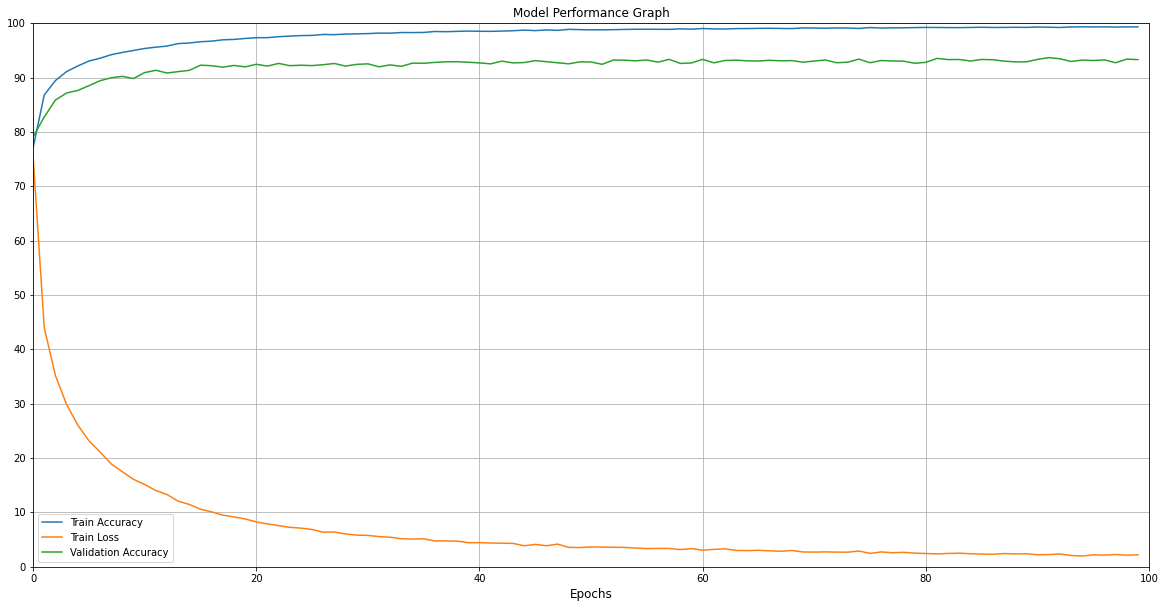

In [18]:
fig = plt.figure(figsize=(20,10))
plt.title("Model Performance Graph")

plt.plot(train_acc, label='Train Accuracy')
plt.plot((train_loss), label='Train Loss')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs', fontsize=12)
ticks = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plt.yticks(ticks)
plt.xlim([0, n_epochs])
plt.ylim([0, 100])
plt.grid()
plt.legend(loc='best')

In [19]:
print("Hyper Parameters Used:")
print("```````````````````````")
print("No of Epoch : ",n_epochs)
print("Learning Rate : ",lr)
print("Batch Size : ",batch_size)

Hyper Parameters Used:
```````````````````````
No of Epoch :  100
Learning Rate :  0.001
Batch Size :  32


## Model performance on Last Epoch

In [20]:
# Model performance on Last Epoch
print(f"\nModel's Performance on Last ({n_epochs}th) Epoch: ")
print("------------------------------------------")
print(f"Epoch: {n_epochs}  |  Train Accuracy: {(train_acc[-1]):.2f} %  |  Train Loss:  {(train_loss[-1]):.2f} %  |  Validation Accuracy: {(val_acc[-1]):.2f} %")


Model's Performance on Last (100th) Epoch: 
------------------------------------------
Epoch: 100  |  Train Accuracy: 99.32 %  |  Train Loss:  2.20 %  |  Validation Accuracy: 93.30 %
